## Weather Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for weather classification. We will use a dataset collected using the Luxottica **iSee** glasses. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection.

![I-SEE Glasses](data/isee.png "I-SEE")

The dataset corresponds to 8 hours of atmospherical data recordings sampled every 3 seconds.

The dataset labels are the following:

| ID  | Label       |
| :-: | :-:         |
| 0   | Sunny       |
| 1   | Rain        |
| 2   | Cloudy      |
| 3   | Mostly Clear|

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline

import typing as tp
import numpy as np
import itertools
from matplotlib import pyplot as plt
import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn import linear_model


1. `load_dataset` -> to load the dataset from the file `data/lux.npz`,
2. `plot_input` -> to plot the input data,
3. `k_split` ->  to split the trainig dataset in k different folds,
4. `k_fold_cross_validation` -> to perform the k-fold cross validation.



In [2]:
# Helper function to load the dataset
def load_dataset(path: str) -> tp.Tuple[np.ndarray, np.ndarray]:
    with np.load(path) as data:
        x, y = data["x"], data["y"]
        
        # Normalize the data
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
        
    return x, y

In [3]:
# Function for plotting a image and printing the corresponding label
def plot_input(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)
    cbar.ax.set_yticklabels(['Sunny', 'Rainy','Cloudy', 'Mostly clear']) 

In [4]:
# Function to split the dataset in k different folds
def k_split(x: np.ndarray, y:np.ndarray, k: int, shuffle: bool = True) -> tp.Tuple[list[np.ndarray], list[np.ndarray]]:
    # Shuffle the dataset
    if shuffle:
        # Create a list of indices
        idx = np.arange(x.shape[0])
        # Randomly shuffle the indices
        np.random.shuffle(idx)
        # Shuffle the dataset
        x = x[idx]
        y = y[idx]

    # Split the dataset in k folds

        x_folds = np.array_split(x, k)
        y_folds = np.array_split(y, k)

    return x_folds, y_folds

In [5]:
# Function to perform the k-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, model: SVC, parameters: dict) -> tp.Tuple[tuple, tuple]:
    # Define the folds for the cross validation
    x_folds, y_folds = k_split(x_train, y_train, k)

    # Build a list containing all of the possible combinatioon of parameters
    params = list(itertools.product(*parameters.values()))

    # Initialize the dictionary of results
    results = {k: 0 for k in params}

    # For each param combination, perform the SVM training and testing
    for param in params:
        param = dict(zip(parameters.keys(), param))

        fold_accuracies = []
        
        
        for i in range(k):
            # Get the training and validation sets for the current fold
            x_train_fold = np.concatenate([x_folds[j] for j in range(k) if j != i])
            y_train_fold = np.concatenate([y_folds[j] for j in range(k) if j != i])
            x_val_fold = x_folds[i]
            y_val_fold = y_folds[i]

            # Initialize the SVM model with the current set of parameters
            model.set_params(**param)

            # Train the SVM model
            model.fit(x_train_fold, y_train_fold)

            # Test the model on the validation fold and store the accuracy
            y_val_pred = model.predict(x_val_fold)
            accuracy = skm.accuracy_score(y_val_fold, y_val_pred)
            fold_accuracies.append(accuracy)


        # Compute the mean accuracy
        results[tuple(param.values())] = round(np.mean(fold_accuracies), 4)
    
    # Find the best parameters
    best_parameters = dict(zip(parameters.keys(), params[np.argmax(list(results.values()))]))
    best_accuracy = np.max(list(results.values()))
    best = (best_parameters, best_accuracy)

    # Add the param name to the results
    results = [({k: v for k, v in zip(parameters.keys(), p)}, a) for p, a in results.items()]

    return best, results

In [6]:
ID = 1234567 
np.random.seed(ID)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (while the **training** set is **typically larger**, here we set the number of training samples to 1000 and 4000 for the test data).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above.

In [7]:
# Load the dataset using the helper function
X, y = load_dataset("data/lux.npz")
print(X.shape, y.shape)

(15099, 3) (15099,)


In [8]:
# The task is quite easy, let's add noise to make it more challenging!
# You can try without noise (comment the next 2 lines, easy task), with the suggested amount of noise,
# or play with the suggested amount of noise 

noise = np.random.normal(0, 0.1, X.shape)
X = X + noise

In [9]:
# Random permute the data and split into training and test taking the first 1000
# data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0]) # ADD YOUR CODE HERE (replace None)

X = X[permutation]
y = y[permutation]

m_training = 1000
m_test = 4000

X_train = X[:m_training]
X_test = X[m_training:m_training + m_test]
y_train = y[:m_training] 
y_test = y[m_training:m_training + m_test] 

print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

X_train shape: (1000, 3) X_test shape: (4000, 3) || y_train shape: (1000,) y_test shape: (4000,)
Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [425 160 357  58]


C:\Users\aysim\AppData\Local\Temp\ipykernel_4060\31676135.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent', 4)


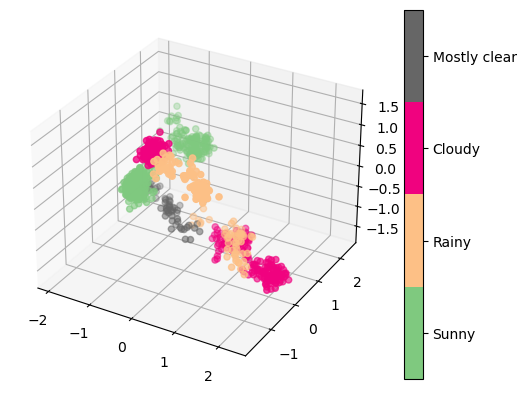

In [10]:
#Let's try the plotting function
plot_input(X_train,y_train)

In [11]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]}

# Define the model (without parameters)
svm =  SVC(kernel='linear') 

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k=4, model=svm, parameters=parameters) 
print ('RESULTS FOR LINEAR KERNEL')

print("Best parameter set found:")
# ADD YOUR CODE HERE
print( best[0])
print("Score with best parameter:")
# ADD YOUR CODE HERE
print( best[1])
print("All scores on the grid:")
# ADD YOUR CODE HERE
for params, score in results:
    print(f"Parameter set: {params}, Score: {score}")

RESULTS FOR LINEAR KERNEL
Best parameter set found:
{'C': 10}
Score with best parameter:
0.907
All scores on the grid:
Parameter set: {'C': 0.01}, Score: 0.778
Parameter set: {'C': 0.1}, Score: 0.897
Parameter set: {'C': 1}, Score: 0.906
Parameter set: {'C': 10}, Score: 0.907


In [12]:
# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm = SVC(kernel='poly', degree=2) 

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k=4, model=poly2_svm, parameters=parameters)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')

print("Best parameter set found:")

print( best[0])

print("Score with best parameter:")

print( best[1])
print()
print("All scores on the grid:")

for params, score in results:
    print(f"Parameter set: {params}, Score: {score}")

RESULTS FOR POLY DEGREE=2 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1.0}
Score with best parameter:
0.941

All scores on the grid:
Parameter set: {'C': 0.01, 'gamma': 0.01}, Score: 0.425
Parameter set: {'C': 0.01, 'gamma': 0.1}, Score: 0.425
Parameter set: {'C': 0.01, 'gamma': 1.0}, Score: 0.85
Parameter set: {'C': 0.1, 'gamma': 0.01}, Score: 0.425
Parameter set: {'C': 0.1, 'gamma': 0.1}, Score: 0.773
Parameter set: {'C': 0.1, 'gamma': 1.0}, Score: 0.932
Parameter set: {'C': 1, 'gamma': 0.01}, Score: 0.425
Parameter set: {'C': 1, 'gamma': 0.1}, Score: 0.85
Parameter set: {'C': 1, 'gamma': 1.0}, Score: 0.941


In [13]:
# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm =  SVC(kernel='poly', degree=degree) 

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k=4, model=poly_svm, parameters=parameters) 

print (f"RESULTS FOR POLY DEGREE={degree} KERNEL")

print("Best parameter set found:")

print(best[0])
print("Score with best parameter:")

print(best[1])
print()
print("All scores on the grid:")

for params, score in results:
    print(f"Parameter set: {params}, Score: {score}")

RESULTS FOR POLY DEGREE=3 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1}
Score with best parameter:
0.937

All scores on the grid:
Parameter set: {'C': 0.01, 'gamma': 0.01}, Score: 0.425
Parameter set: {'C': 0.01, 'gamma': 0.1}, Score: 0.425
Parameter set: {'C': 0.01, 'gamma': 1}, Score: 0.868
Parameter set: {'C': 0.1, 'gamma': 0.01}, Score: 0.425
Parameter set: {'C': 0.1, 'gamma': 0.1}, Score: 0.52
Parameter set: {'C': 0.1, 'gamma': 1}, Score: 0.921
Parameter set: {'C': 1, 'gamma': 0.01}, Score: 0.425
Parameter set: {'C': 1, 'gamma': 0.1}, Score: 0.733
Parameter set: {'C': 1, 'gamma': 1}, Score: 0.937


In [14]:
# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = SVC(kernel='rbf')  

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k=4, model=rbf_svm, parameters=parameters) 
print ('RESULTS FOR rbf KERNEL')

print("Best parameter set found:")

print(best[0])
print("Score with best parameter:")

print(best[1])
print()
print("All scores on the grid:")

for params, score in results:
    print(f"Parameter set: {params}, Score: {score}")

RESULTS FOR rbf KERNEL
Best parameter set found:
{'C': 10, 'gamma': 1}
Score with best parameter:
0.992

All scores on the grid:
Parameter set: {'C': 0.1, 'gamma': 0.001}, Score: 0.425
Parameter set: {'C': 0.1, 'gamma': 0.01}, Score: 0.606
Parameter set: {'C': 0.1, 'gamma': 0.1}, Score: 0.85
Parameter set: {'C': 0.1, 'gamma': 1}, Score: 0.948
Parameter set: {'C': 1, 'gamma': 0.001}, Score: 0.605
Parameter set: {'C': 1, 'gamma': 0.01}, Score: 0.831
Parameter set: {'C': 1, 'gamma': 0.1}, Score: 0.95
Parameter set: {'C': 1, 'gamma': 1}, Score: 0.987
Parameter set: {'C': 10, 'gamma': 0.001}, Score: 0.812
Parameter set: {'C': 10, 'gamma': 0.01}, Score: 0.906
Parameter set: {'C': 10, 'gamma': 0.1}, Score: 0.986
Parameter set: {'C': 10, 'gamma': 1}, Score: 0.992
Parameter set: {'C': 100, 'gamma': 0.001}, Score: 0.901
Parameter set: {'C': 100, 'gamma': 0.01}, Score: 0.964
Parameter set: {'C': 100, 'gamma': 0.1}, Score: 0.99
Parameter set: {'C': 100, 'gamma': 1}, Score: 0.987


In [15]:
# Get training and test error for the best SVM model from CV
best_svm = SVC(kernel='rbf', C=best[0]['C'], gamma=best[0]['gamma'])
# Run the svm model on the whole training set
best_svm.fit(X_train, y_train)
# Compute the errors
# (error is 1 - svm.score)
training_error = 1 - best_svm.score(X_train, y_train) 
test_error = 1 - best_svm.score(X_test, y_test) 

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.006000
Best SVM test error: 0.013750


In [16]:
# Test with different values of gamma
# use rbf kernel and C=1

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print(gamma_values)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


In [17]:
train_acc_list, test_acc_list = [], []

for gamma in gamma_values:
    svm = SVC(kernel='rbf', C=1, gamma=gamma)
    
    # Train the SVM on the training data
    svm.fit(X_train, y_train)
    
    # Calculate training accuracy
    train_accuracy = svm.score(X_train, y_train)
    train_acc_list.append(train_accuracy)
    
    # Calculate test accuracy
    test_accuracy = svm.score(X_test, y_test)
    test_acc_list.append(test_accuracy)

# Print the results
print("Gamma values:", gamma_values)
print("Training accuracies:", train_acc_list)
print("Test accuracies:", test_acc_list)

Gamma values: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
Training accuracies: [0.425, 0.425, 0.605, 0.869, 0.959, 0.991, 0.994, 0.994]
Test accuracies: [0.3975, 0.3975, 0.591, 0.8555, 0.9445, 0.98525, 0.98775, 0.91525]


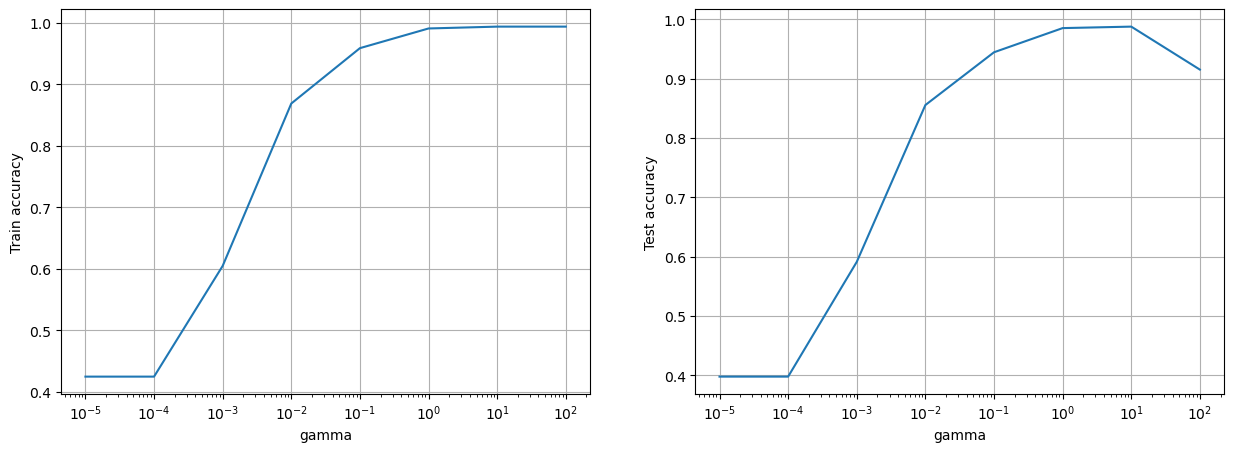

In [18]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()

In [19]:
X = X[permutation]
y = y[permutation]

m_training = 11000 

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True) 
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# initialize support variables for boundaries visualization
granularity = 25
x_max = np.abs(X).max()
x_range = np.linspace(-x_max, x_max, granularity)
x_grid = np.stack(np.meshgrid(x_range, x_range, x_range)).reshape(3, -1).T

Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [4450 1846 4004  700]


In [20]:
# Get training and test error for the best SVM model from CV
# Set the best parameters obtained from cross-validation
best_svm_params = {'C': best[0]['C'], 'gamma': best[0]['gamma']}

# Initialize SVM model with the best parameters
best_svm_model = SVC(**best_svm_params)

# Train the SVM model on the entire training set
best_svm_model.fit(X_train, y_train)

# Run the SVM model on the whole training set and compute errors
training_error = 1 - best_svm_model.score(X_train, y_train)
test_error = 1 - best_svm_model.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.008818
Best SVM test error: 0.009515


In [21]:
rbf_svm_test = rbf_svm.predict(X_test) 

(-2.7071737952621224, 2.7071737952621224)

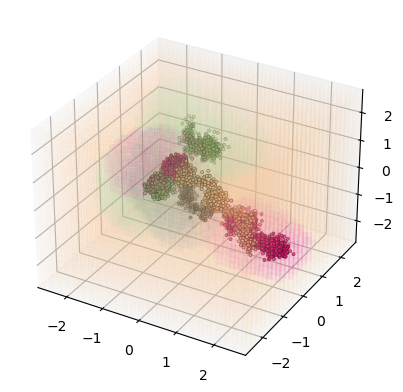

In [22]:
rbf_SVM_grid = rbf_svm.predict(x_grid)

rbf_SVM_m = y_test == rbf_svm_test

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection="3d")

ax1.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax1.scatter(X_test[rbf_SVM_m,0], X_test[rbf_SVM_m,1], X_test[rbf_SVM_m,2], c=y_test[rbf_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax1.scatter(X_test[~rbf_SVM_m,0], X_test[~rbf_SVM_m,1], X_test[~rbf_SVM_m,2], c=y_test[~rbf_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax1.set_xlim([-x_max, x_max])
ax1.set_ylim([-x_max, x_max])
ax1.set_zlim([-x_max, x_max])

In [23]:
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM = skm.confusion_matrix(y_test, rbf_svm_test)
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

Labels and frequencies in test set:  [1668  682 1519  230]

 Confusion matrix SVM  
 
 [[1668    0    0    0]
 [   0  668   14    0]
 [   0   35 1484    0]
 [   0    3    0  227]]

 Confusion matrix SVM (normalized)   
 
 [[1.   0.   0.   0.  ]
 [0.   0.98 0.02 0.  ]
 [0.   0.02 0.98 0.  ]
 [0.   0.01 0.   0.99]]


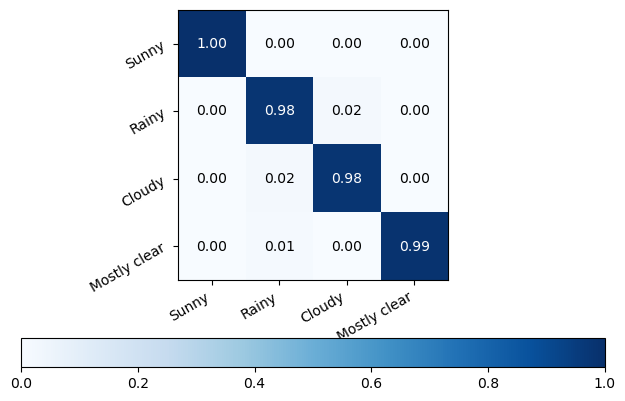

In [24]:
fig = plt.figure()
    
im = plt.imshow(confusion_SVM /counts[:,None], cmap="Blues",interpolation='nearest')
plt.xticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
plt.yticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
cm = confusion_SVM /counts[:,None]
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im, location='bottom')  
plt.show()